# Final Project Baseline
Yang Wei Neo, Emily Rapport, Hilary Yamtich

## Load Libraries and Data

In [9]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import csv
from rfpimp import *
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA 
# note: this notebook requires pandas 0.21.0 or newer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shared_functions as sf
import math
from datetime import datetime as dt
import re as re
import pickle as pk

# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO

from dateutil import parser
import datetime

In [10]:
# Basic EDA
# The training data needs to be saved in the same location.
original_data = pd.read_csv('train.csv')
data = original_data.copy()

# Background to the problem

### The Dataset and Framing the Problem

The goal of this problem is to use the Ames Housing Dataset to create a model to predict the sale prices of homes randomly selected from within the original dataset. 

The Ames Housing Dataset was compiled by Dean De Cock in 2011. It is based on all the housing sales that occured in Ames, Iowa during the period from 2006 to 2010. It was created as an alternative to the Boston Housing Dataset and it includes more feature variables (79) that are related to housing price. The original dataset included 2,390 observations. The goal of the creator was to include a wider set of explanatory variables than the original Boston Housing Dataset to allow for more advanced regression techniques to be applied.

The problem itself is based on Kaggle competition to use advanced regression techniques to create a model to predict the sale price of a home. The test data is randomly selected from within the original Ames Housing Dataset. The training dataset used in the Kaggle competition includes 1,460 observations. The goal is to accurately predict the sale prices of the homes in the test set.

### Distribution of Sale Price Variable

First we look at the distribution of the sale price variable using a histogram.

Text(0.5,0,'Sale Prices')

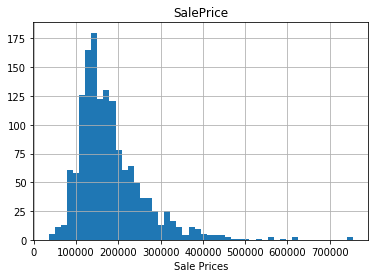

In [11]:
data.hist("SalePrice", bins = 50)
plt.xlabel("Sale Prices")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1147dec50>]],
      dtype=object)

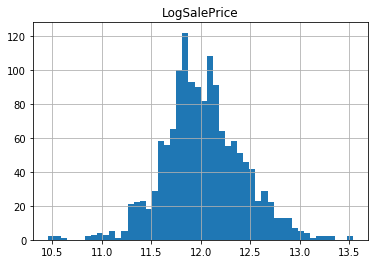

In [12]:
data["LogSalePrice"] = np.log(data["SalePrice"])
data.hist("LogSalePrice", bins = 50)

This produces a more normally distributed set of data. This makes our highly skewed distribution less skewed and allows our sale price data to meet the assumptions of inferential statistics and linear regression.

## Exploratory Data Analysis

## Feature Engineering

### Overview

We have two broad approaches to feature engineering - 'top down' and 'bottom up'. 

In the 'top down' case, we start with all the variables and work to eliminate / simplify variables as much as possible. We remove features with little useful variation (mostly missing, or heavily imbalanced) and features that are highly correlated for obvious reasons (e.g. total square feet and other component square feet). These should help to reduce the likelihood of overfitting and help improve interpretability. 

In the 'bottom up' case, we use various algorithmic feature selection techniques (e.g. random forest feature importance) and choose the top 10. This helps us construct the most parsimonious feature set to compare our more complete feature set against. 

In both cases, we also make several variable transformations - imputing missing features, or one-hot-encoding categorical features, for instance. They are listed below. 

### Remove features with very little variation and those that are missing for most observations

Based on this heatmap of missing variables we see that Alley, PoolQC, Fence and MiscFeature are missing for most values in the dataset. This makes sense, as these are more esoteric features of the house. In the same vein, there is also very little variation in Street, Utilities, LowQualFinSF and MiscVal. For example, most of these houses have all the utilities except for one. While this may ultimately be an important predictor, we believe that this is more likely to overfit and not generalize (after all this observation can only be in validation or train) for any given fold.

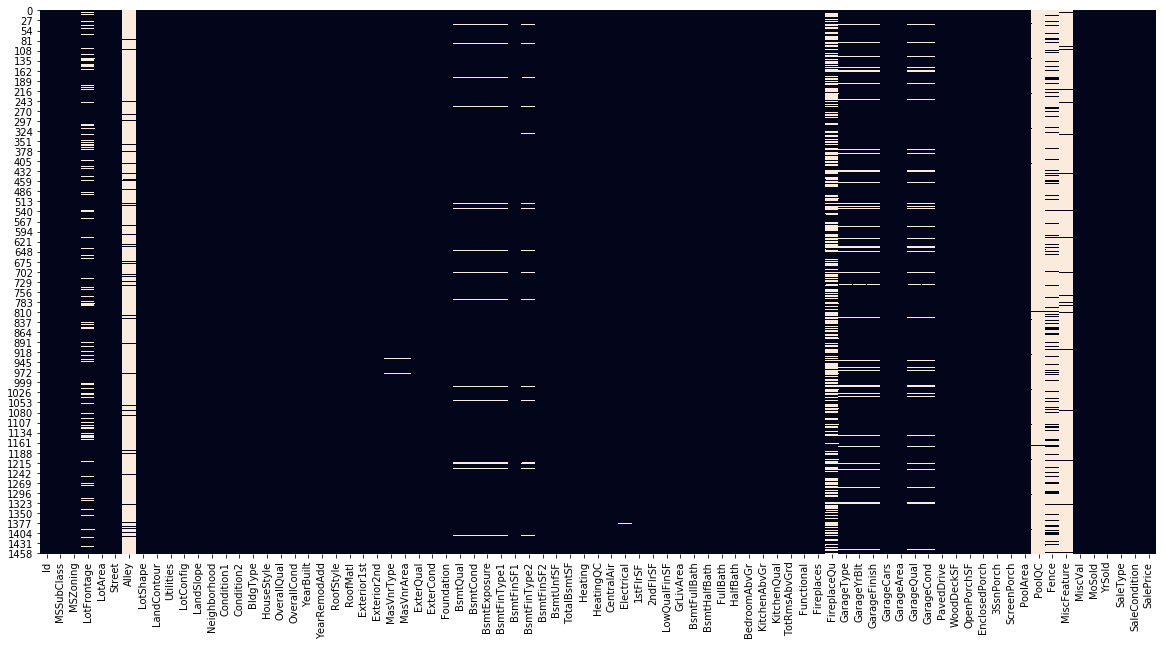

In [13]:
plt.figure(figsize=(20,10))
sns.heatmap(original_data.isnull(), cbar=False)
data = data.drop(columns=['Alley', 'PoolQC', 'Fence', 'MiscFeature'])

# Drop variables with very imblanced categories or mostly missing
data = data.drop(columns = ['Street', 'Utilities', 'LowQualFinSF', 'MiscVal'])

### Remove features that are redundant given other variables

We then remove aggregated variables that are very close to the sum of its component parts. For instance, TotalBsmtSF is the approximately sum of the BsmtFinSF1, BSmtUnfSF and BsmtFinSF2. Likewise with GrLivArea. There are some minor discrepancies, but I assume that those are immaterial for our analysis and not large/frequent enough to matter. 

GarageArea / GarageCars is an interesting case, as these two variables capture a similar concept. Indeed, the two variables are highly correlated (see chart below). We keep both in for now, but may decide to remove the 'less informative' one later (e.g. GarageCars). 

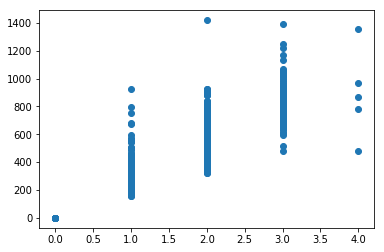

In [14]:
##################
### BASEMENTSF ###
# Drop the aggregate BsmtSF variable
test = pd.DataFrame()
test['DiffBsmtSF'] = original_data["TotalBsmtSF"] - original_data['BsmtFinSF1'] - original_data['BsmtUnfSF'] - original_data['BsmtFinSF2']
test['DiffBsmtSF'].value_counts()

# Remove variable
data = data.drop(columns=['TotalBsmtSF'])

##################
### GRLIVAREA ###
# Is GrLivArea simply the sum of 1st and 2nd?
# Most of hte time it is - there are 5 observations that are not, but doesn't seem like a goood reason to keep
test = pd.DataFrame()
test['GrLivArea'] = original_data["GrLivArea"]
test['1stAnd2nd'] = original_data["1stFlrSF"] + original_data["2ndFlrSF"]
test['Diff'] = test['GrLivArea'] - test['1stAnd2nd']
test['Diff'].value_counts()

###################
### GARAGECARS ###
data = data.drop(columns = ['GrLivArea'])
original_data['GarageCars'].value_counts()
plt.scatter(original_data['GarageCars'],original_data['GarageArea'])
#data = data.drop(columns=['GarageCars']) # KEEP FOR NOW, but garage area may be better than garage cars

###################
### DATETIME    ###
# Change date to ordinal representation:
data['YrMoSold'] = data['YrSold'].astype(int).astype(str) + "/" + data['MoSold'].astype(int).astype(str) + "/1"
data['YrMoSold'] = data['YrMoSold'].apply(lambda x: dt.strptime(x, "%Y/%m/%d").date().toordinal())

### Impute features

We use the median values to impute missing values to control for possible outliers. We also do not impute any missing categories for now (they will receive 0 across all one-hot encoded dummy variables). In a later analysis, we might do more complex imputation of these missing values. 

In [15]:
#############################
# Impute all numeric missings (all dummy missings are coded 0)
imp = SimpleImputer(missing_values = np.nan, strategy = 'median')
data_numeric = imp.fit_transform(data.select_dtypes(exclude='object'))
data_numeric = pd.DataFrame(data_numeric, columns = data.select_dtypes(exclude='object').columns)
data = pd.concat([data.select_dtypes(include='object'), data_numeric], axis = 1)

### Combine sparse categories in some features

Condition and Exterior features have many sparse levels - we group levels that have very few observations to obtain a bigger category. 

In [16]:
# Combine categories - very thin categories
# Condition1
data['Condition1'] = np.where(data['Condition1']=='Norm', 'Norm', 'Not_Norm')
data['Condition2'] = np.where(data['Condition2']=='Norm', 'Norm', 'Not_Norm')

# Exterior1st
data['Exterior1st'] = np.where(data['Exterior1st'].isin(['BrkComm', 'Stone', 'AsphShn', 'ImStucc', "CBlock", "WdShing", "Stucco", "AsbShng"]), 'Other', data['Exterior1st'])
data['Exterior2nd'] = np.where(data['Exterior2nd'].isin(['Brk Cmn', 'Stone', 'AsphShn', 'Other', "CBlock", "WdShing", "Stucco", "AsbShng"]), 'Other', data['Exterior1st'])


### One-Hot-Encoding for Categoricals

We use one-hot encoding to encode categorical features and combine the condition and exterior variables into one variable each. 

In [17]:
##########################
# Binarize all categorical (one-hot)
data = pd.get_dummies(data)

In [18]:
# Simplify the Condition Feature
data['Condition_Norm'] = data['Condition1_Norm'] + data['Condition2_Norm']
data['Condition_Not_Norm'] = data['Condition1_Not_Norm'] + data['Condition2_Not_Norm']
data['Condition_Norm'] = np.where(data['Condition_Norm']==2, 1, data['Condition_Norm'])
data['Condition_Not_Norm'] = np.where(data['Condition_Not_Norm']==2, 1, data['Condition_Not_Norm'])

# Simplify the Exterior Feature
data['Exterior_VinylSd'] = data['Exterior1st_VinylSd'] + data['Exterior2nd_VinylSd']
data['Exterior_HdBoard'] = data['Exterior1st_HdBoard'] + data['Exterior2nd_HdBoard']
data['Exterior_MetalSd'] = data['Exterior1st_MetalSd'] + data['Exterior2nd_MetalSd']
data['Exterior_Wd Sdng'] = data['Exterior1st_Wd Sdng'] + data['Exterior2nd_Wd Sdng']
data['Exterior_Plywood'] = data['Exterior1st_Plywood'] + data['Exterior2nd_Plywood']
data['Exterior_Other']   = data['Exterior1st_Other']   + data['Exterior2nd_Other']
data['Exterior_CemntBd'] = data['Exterior1st_CemntBd'] + data['Exterior2nd_CemntBd']
data['Exterior_BrkFace'] = data['Exterior1st_BrkFace'] + data['Exterior2nd_BrkFace']

data['Exterior_VinylSd'] = np.where(data['Exterior_VinylSd'] == 2, 1, data['Exterior_VinylSd'])
data['Exterior_HdBoard'] = np.where(data['Exterior_HdBoard'] == 2, 1, data['Exterior_HdBoard'])
data['Exterior_MetalSd'] = np.where(data['Exterior_MetalSd'] == 2, 1, data['Exterior_MetalSd'])
data['Exterior_Wd Sdng'] = np.where(data['Exterior_Wd Sdng'] == 2, 1, data['Exterior_Wd Sdng'])
data['Exterior_Plywood'] = np.where(data['Exterior_Plywood'] == 2, 1, data['Exterior_Plywood'])
data['Exterior_Other'] = np.where(data['Exterior_Other'] == 2, 1, data['Exterior_Other'])
data['Exterior_CemntBd'] = np.where(data['Exterior_CemntBd'] == 2, 1, data['Exterior_CemntBd'])
data['Exterior_BrkFace'] = np.where(data['Exterior_BrkFace'] == 2, 1, data['Exterior_BrkFace'])

cols_to_drop = list(filter(lambda x: re.search(r'Condition1|Condition2|Exterior1|Exterior2', x), data.columns))
data = data.drop(columns=cols_to_drop)

### Convert features to the right type

In [19]:
data['OverallQual'] = original_data['OverallQual'].astype('category')
data['OverallCond'] = original_data['OverallCond'].astype('category', ordered=True)
data['MSSubClass'] = original_data['MSSubClass'].astype('category')

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


### Add new features

In [20]:
data['Basement'] = np.where(data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['BsmtUnfSF'] > 1, 1, 0)
data['WoodDeck'] = np.where(data['WoodDeckSF'] > 0, 1, 0)

### PCA: 2 Features explain almost 100% of the variance in the data!

In [21]:
pca = PCA(n_components=50)
data_pca = pca.fit_transform(data.drop(columns=['YrMoSold', 'SalePrice', 'Id']))
pca_names = ['pca_' + str(i) for i in range(50)]
data_pca = pd.DataFrame(data_pca, columns=pca_names)
print(pca.explained_variance_ratio_)

data = pd.concat([data.reset_index(drop=True), data_pca], axis = 1)

[9.91492429e-01 3.03585068e-03 2.38210067e-03 1.73903466e-03
 3.98075445e-04 2.94316844e-04 2.29259949e-04 1.42920379e-04
 1.27590771e-04 4.14772066e-05 3.37789633e-05 2.90585296e-05
 1.56770147e-05 1.51814784e-05 8.47925377e-06 8.01274878e-06
 3.05952329e-06 2.05893996e-06 1.41494075e-06 7.23678914e-08
 1.69298406e-08 1.04473238e-08 9.53567334e-09 7.95163433e-09
 4.91919836e-09 4.72318476e-09 4.25050127e-09 3.53852329e-09
 3.17500597e-09 2.97908569e-09 2.79744900e-09 2.71875340e-09
 2.61053783e-09 2.39223333e-09 2.29854552e-09 2.22230185e-09
 2.04185339e-09 1.92650813e-09 1.89503981e-09 1.84080650e-09
 1.74852353e-09 1.73838597e-09 1.68685659e-09 1.67870022e-09
 1.56852480e-09 1.50914530e-09 1.43449107e-09 1.42546486e-09
 1.34405657e-09 1.31701411e-09]


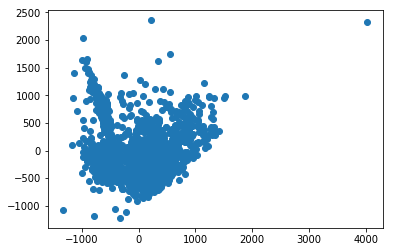

In [22]:
plt.scatter(x = data_pca['pca_1'], y = data_pca['pca_2'])

In [23]:
pd.set_option('display.max_columns', None)  
data.iloc[data_pca[data_pca['pca_1'] < 50000].index].describe() 

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,SalePrice,LogSalePrice,YrMoSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Condition_Norm,Condition_Not_Norm,Exterior_VinylSd,Exterior_HdBoard,Exterior_MetalSd,Exterior_Wd Sdng,Exterior_Plywood,Exterior_Other,Exterior_CemntBd,Exterior_BrkFace,Basement,WoodDeck,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,146

In [24]:
data.iloc[data_pca[data_pca['pca_1'] > 50000].index] 
# these are homes with extremely large lot areas relative to the sample.

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,SalePrice,LogSalePrice,YrMoSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Condition_Norm,Condition_Not_Norm,Exterior_VinylSd,Exterior_HdBoard,Exterior_MetalSd,Exterior_Wd Sdng,Exterior_Plywood,Exterior_Other,Exterior_CemntBd,Exterior_BrkFace,Basement,WoodDeck,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49


### Some basic feature importance to sense check

We do two types of feature importance checks:
- First we investigate the pairwise correlation between all variables and identify any set variables that are highly correlated. This led us to discover the redundant sets of variables discussed above.
- Second we use the Random Forest feature importance algorithm to identify the variables that lead to the largest information gain. This mostly makes sense and we use this to construct the 'bottom up' dataset. 

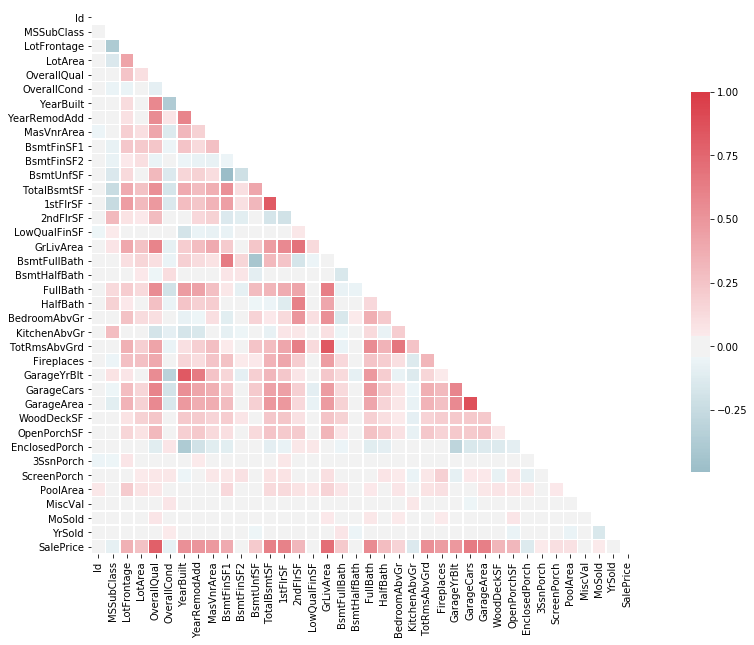

In [25]:
# Correlation matrix
plt.figure(figsize=(20,10))
corr = original_data.select_dtypes(exclude='object').corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

### Use an algorithmic Feature Selection method

In [26]:
remove_variables = ['SalePrice']

rf = RandomForestRegressor()
rf.fit(data.drop(columns=['SalePrice']), data['SalePrice'])
rf.feature_importances_

feature_importances = pd.DataFrame(rf.feature_importances_.round(4),
                                   index = data.drop(columns=['SalePrice']).columns, columns=['importance']).sort_values('importance', ascending=False)

feature_importances[0:10]

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,importance
LogSalePrice,0.9877
pca_12,0.0040
MasVnrArea,0.0037
LotConfig_Corner,0.0010
pca_23,0.0006
pca_40,0.0006
pca_36,0.0005
WoodDeckSF,0.0005
pca_21,0.0003
pca_1,0.0001


In [33]:
# Final data to CSV file
data.to_csv('clean_data.csv')

# Final data to pickle file
outfile = open('clean_data_pickle','wb')
pk.dump(data, outfile)
outfile.close()

In [ ]:
### Create a really simple version with 10 variables
most_impt_cols = list(feature_importances[:10].index)
most_impt_cols.append('SalePrice')

def get_simple_data(input_data, colnames):
    output_data = input_data[colnames]
    return(output_data)
    
simple_data = get_simple_data(data, most_impt_cols)